# Run GNN Models

In [1]:
import numpy as np 
import pandas as pd
import pickle
import os
import networkx as nx
import dgl
import torch

/home/dsi/orrbavly/miniconda3/envs/torchgpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
with open("/dsi/sbm/OrrBavly/colon_data/graphs/G_overlap_lcc_246_gnn.pkl", 'rb') as f:
    G_overlap = pickle.load(f)
node_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon/g_overlap_lcc_246_node_meta_gnn.csv")
node_meta = node_meta.loc[:, ~node_meta.columns.str.contains('^Unnamed')]
colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
valid_samples = colon_meta[colon_meta['N'].isin(['0', '1', '1a', '1b', '2'])]['sample_id'].tolist()


In [122]:
# Correct way to get the first edge and its attributes:
u, v, edge_data = next(iter(G_overlap.edges(data=True)))
print(f"Edge ({u}, {v}) attributes: {edge_data}")

Edge (CASSLGRGSGANVLTF, CASSLGGGTYNEQFF) attributes: {'fast_weight': 0.6620007927103068, 'slow_weight': 0.7661279664234611}


In [121]:
all_keys = set()
for _, _, data in G_overlap.edges(data=True):
    all_keys.update(data.keys())
print("All edge feature names:", all_keys)

All edge feature names: {'fast_weight', 'slow_weight'}


In [3]:
relevant_values = ['0', '1', '1a', '1b', '2']
# List of samples to exclude - did not undergo mixcr due to missing lanes.
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18']
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()
colon_meta

filename  sum value   T   N   M sample_id
0     pool1_S1_TRB_mig_cdr3_clones_all      33296  T3  1b  Mx     P1-S1
2    pool1_S11_TRB_mig_cdr3_clones_all      78560  T2   0  Mx    P1-S11
3    pool1_S12_TRB_mig_cdr3_clones_all     190517  T3   0  Mx    P1-S12
4    pool1_S13_TRB_mig_cdr3_clones_all      72593  T3   0   0    P1-S13
7    pool1_S16_TRB_mig_cdr3_clones_all     270087  T4   1   0    P1-S16
..                                 ...        ...  ..  ..  ..       ...
209   pool9_S3_TRB_mig_cdr3_clones_all     190092  T1   0   0     P9-S3
210   pool9_S4_TRB_mig_cdr3_clones_all     198511  T2   1   0     P9-S4
211   pool9_S5_TRB_mig_cdr3_clones_all      62094  T3   1   0     P9-S5
213   pool9_S7_TRB_mig_cdr3_clones_all     170894  T2   0   X     P9-S7
214   pool9_S8_TRB_mig_cdr3_clones_all     184919  T3   1  Mx     P9-S8

[160 rows x 6 columns]

In [4]:
# --- File paths ---
mixcr_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750

# --- Load metadata ---
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# --- Load all mixcr files ---
# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]

clonotype_dfs = []


for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        if sample_prefix in valid_samples:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

# Merge all clonotype data
clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")

# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

In [5]:
print(clonotype_df['Sample_ID'].nunique())

160


In [6]:
node_list = list(G_overlap.nodes)
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

In [7]:
def build_sample_graph(sample_id, G_overlap, node_metadata_df, clonotype_df, meta_df, feature_cols, label_col='N'):
    node_list = list(G_overlap.nodes)

    # Step 1: Get sample-specific TCRs (as multiple clonotypes appear in the same sample with different nucleotide seq,
    # we will aggragate its readFraction values across all relevant rows)
    sample_data = (
        clonotype_df[clonotype_df['Sample_ID'] == sample_id]
        .groupby('aaSeqCDR3')[['readFraction']]  # keep only relevant dynamic features
        .sum()  # sum is safe for readFraction; it’s often fractional per chain
    )
    sample_data['present'] = 1  # each TCR now appears once

    # Step 2: Align to node metadata (which is indexed by 'id')
    dynamic_features = (
        sample_data
        .reindex(index=node_metadata_df['id'])
        .fillna(0)
    )

    # 3. Merge static + dynamic node features
    node_features = pd.concat([
        node_metadata_df.set_index('id')[feature_cols],
        dynamic_features
    ], axis=1).reindex(node_list).fillna(0)

    # 4. Convert to tensor
    X = torch.tensor(node_features.values, dtype=torch.float32)

    # 5. Get label
    label_row = meta_df[meta_df['sample_id'] == sample_id]
    if label_row.empty:
        return None  # Skip if no label
    label_value = label_row[label_col].values[0]  # this might be '2', 'sick', etc.
    y_class = 0 if str(label_value) == '0' else 1  # adjust condition as needed
    # Now convert to tensor
    y = torch.tensor([y_class], dtype=torch.long)

    # 6. Build DGL graph
    g_dgl = dgl.from_networkx(G_overlap)
    g_dgl.ndata['feat'] = X
    g_dgl.y = y

    return g_dgl


## GNN

In [8]:
# Define the static node columns to include
feature_cols = [
    'sum_fast_weight', 'avg_fast_weight',
    'sum_slow_weight', 'avg_slow_weight',
    'codon_diversity_fast', 'codon_diversity_slow',
    'sample_prevalence_fast', 'sample_prevalence_slow',
    'V_gene_fast_id', 'J_gene_fast_id',
    'V_gene_slow_id', 'J_gene_slow_id',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

sample_id = meta_df['Sample_ID'].iloc[0]  # one labeled sample
graph = build_sample_graph(
    sample_id,
    G_overlap,
    node_meta,
    clonotype_df,
    colon_meta,
    feature_cols
)

print(graph.ndata['feat'].shape, graph.y)

torch.Size([246, 18]) tensor([1])


Connect to GPU

In [9]:
import logging
def connect_gpu():

    GPU_DEVICE = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        logging.warning("CUDA is not available, using CPU for training.")
    else:
        # Print available devices
        num_devices = torch.cuda.device_count()
        logging.info(f"CUDA is available. Number of devices: {num_devices}")
        print(f"CUDA is available. Number of devices: {num_devices}")

        # Try connecting to the specific device
        try:
            torch.cuda.set_device(GPU_DEVICE)  # SET GPU INDEX HERE:
            current_device = torch.cuda.current_device()
            device_name = torch.cuda.get_device_name(current_device)
            logging.info(f"Using GPU device {current_device}: {device_name}")
            print(f"Using GPU device {current_device}: {device_name}")
        except Exception as e:
            logging.error(f"Failed to connect to GPU: {e}")
            device = torch.device("cpu")
    return device

In [10]:
from dgl.data import DGLDataset

class TCRSampleDataset(DGLDataset):
    def __init__(self, G_overlap, node_metadata_df, clonotype_df, meta_df, feature_cols, label_col='N'):
        self.G_overlap = G_overlap
        self.node_metadata_df = node_metadata_df
        self.clonotype_df = clonotype_df
        self.meta_df = meta_df
        self.feature_cols = feature_cols
        self.label_col = label_col
        super().__init__(name='tcr_sample_dataset')

    def process(self):
        self.graphs = []
        self.labels = []
        node_list = list(self.G_overlap.nodes)

        labeled_samples = self.meta_df.dropna(subset=[self.label_col])['sample_id'].unique()
        print(f"Building graphs for {len(labeled_samples)} labeled samples...")

        for sample_id in labeled_samples:
            g = build_sample_graph(
                sample_id,
                self.G_overlap,
                self.node_metadata_df,
                self.clonotype_df,
                self.meta_df,
                self.feature_cols,
                self.label_col
            )
            if g is not None:
                self.graphs.append(g)
                self.labels.append(g.y)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

def stratified_train_test_split(labels, test_size=0.2, seed=42):
    """
    Split indices into stratified train/test subsets. Focuses on train/test splits, not train/validation split (as split_fold10_manual function does).
    Returns: train_indices, test_indices
    """
    np.random.seed(seed)
    labels = np.array(labels)
    unique_labels = np.unique(labels)

    test_indices = []
    train_indices = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        np.random.shuffle(idx)
        n_test = int(np.floor(test_size * len(idx)))
        test_indices.extend(idx[:n_test])
        train_indices.extend(idx[n_test:])

    return np.array(train_indices), np.array(test_indices)

In [11]:
from dgl.dataloading import GraphDataLoader

# Define the static node columns to include
feature_cols = [
    'sum_fast_weight', 'avg_fast_weight',
    'sum_slow_weight', 'avg_slow_weight',
    'codon_diversity_fast', 'codon_diversity_slow',
    'sample_prevalence_fast', 'sample_prevalence_slow',
    'V_gene_fast_id', 'J_gene_fast_id',
    'V_gene_slow_id', 'J_gene_slow_id',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

# Create dataset
dataset = TCRSampleDataset(
    G_overlap=G_overlap,
    node_metadata_df=node_meta,
    clonotype_df=clonotype_df,
    meta_df=colon_meta,
    feature_cols=feature_cols,
    label_col='N'  # adjust if your label column is named differently
)

Building graphs for 161 labeled samples...


In [12]:
# Optional: split dataset
from sklearn.model_selection import train_test_split

# Step 1: Stratified train+val vs test
labels = [label.item() for _, label in dataset]
train_val_idx, test_idx = stratified_train_test_split(labels, test_size=0.2)

# Step 2: Stratified train vs val (on train_val only)
train_val_labels = [labels[i] for i in train_val_idx]
train_idx, val_idx = stratified_train_test_split(train_val_labels, test_size=0.2)

# Map val_idx to original indices
val_idx = [train_val_idx[i] for i in val_idx]
train_idx = [train_val_idx[i] for i in train_idx]

train_set = [dataset[i] for i in train_idx]
val_set = [dataset[i] for i in val_idx]
test_set = [dataset[i] for i in test_idx]

train_loader = GraphDataLoader(train_set, batch_size=16, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = GraphDataLoader(val_set, batch_size=16, shuffle=False, pin_memory=torch.cuda.is_available())
test_loader = GraphDataLoader(test_set, batch_size=16, shuffle=False, pin_memory=torch.cuda.is_available())


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class GINClassifier(nn.Module):
    def __init__(self, in_feats, hidden_dim, num_classes, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()

        for i in range(num_layers):
            input_dim = in_feats if i == 0 else hidden_dim
            mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(dglnn.GINConv(mlp, learn_eps=True))

        self.pool = dglnn.AvgPooling()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, g, features):
        h = features
        for conv in self.convs:
            h = conv(g, h)
        hg = self.pool(g, h)
        return self.classifier(hg)

from sklearn.metrics import balanced_accuracy_score, f1_score
import time

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for g, label in dataloader:
        g = g.to(device)
        feats = g.ndata['feat'].to(device)
        label = label.to(device)

        optimizer.zero_grad()
        out = model(g, feats)
        loss = criterion(out, label.squeeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds += out.argmax(dim=1).cpu().tolist()
        all_labels += label.cpu().tolist()

    acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for g, label in dataloader:
            g = g.to(device)
            feats = g.ndata['feat'].to(device)
            label = label.to(device)

            out = model(g, feats)
            loss = criterion(out, label.squeeze(1))
            total_loss += loss.item()

            all_preds += out.argmax(dim=1).cpu().tolist()
            all_labels += label.cpu().tolist()

    acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1


In [ ]:
device = connect_gpu()
# Infer input/output dimensions from a sample
sample_graph, sample_label = train_set[0]
in_feats = sample_graph.ndata['feat'].shape[1]
num_classes = len(set([label.item() for _, label in dataset]))

# Model
model = GINClassifier(in_feats=in_feats, hidden_dim=64, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe


In [15]:
import copy

best_val_acc = 0
best_model = None

n_epochs = 50
for epoch in range(n_epochs):
    t0 = time.time()
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, F1: {train_f1:.3f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, F1: {val_f1:.3f} | "
            f"Time: {time.time() - t0:.2f}s")


Epoch 01 | Train Loss: 3.1547, Acc: 0.509, F1: 0.507 | Val Loss: 1.2314, Acc: 0.500, F1: 0.390 | Time: 10.36s
Epoch 06 | Train Loss: 0.6737, Acc: 0.500, F1: 0.390 | Val Loss: 0.8252, Acc: 0.500, F1: 0.390 | Time: 0.07s
Epoch 11 | Train Loss: 0.6583, Acc: 0.500, F1: 0.390 | Val Loss: 0.7278, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 16 | Train Loss: 0.6630, Acc: 0.500, F1: 0.390 | Val Loss: 0.7207, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 21 | Train Loss: 0.6596, Acc: 0.500, F1: 0.390 | Val Loss: 0.7169, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 26 | Train Loss: 0.6546, Acc: 0.500, F1: 0.390 | Val Loss: 0.7161, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 31 | Train Loss: 0.6517, Acc: 0.500, F1: 0.390 | Val Loss: 0.7392, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 36 | Train Loss: 0.6568, Acc: 0.500, F1: 0.390 | Val Loss: 0.7434, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 41 | Train Loss: 0.6556, Acc: 0.500, F1: 0.390 | Val Loss: 0.7459, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 46 | Train L

In [16]:
# Final evaluation on test set
print("\n🔍 Evaluating best model on test set...")
test_loss, test_acc, test_f1 = evaluate(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.3f}, F1: {test_f1:.3f}")


🔍 Evaluating best model on test set...
Test Loss: 0.9287, Acc: 0.500, F1: 0.392


## GNN round 2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import dgl
import pandas as pd
from sklearn.preprocessing import StandardScaler

class SingleGraphSampleDataset(Dataset):
    """
    One item = (graph, dyn_features, presence_mask, label)
    dyn_features  : FloatTensor [num_nodes, D_dyn]
    presence_mask : BoolTensor  [num_nodes]  (True for nodes that appear in sample)
    """
    def __init__(
        self, 
        g_overlap: dgl.DGLGraph,
        node_static_df: pd.DataFrame,
        dynamic_tensor_dict: dict,   # sample_id -> FloatTensor[num_nodes, D_dyn]
        presence_mask_dict: dict,    # sample_id -> BoolTensor[num_nodes]
        label_series: pd.Series,     # index=sample_id, value=label
    ):
        self.g = g_overlap
        # store static features inside the graph once
        self.g.ndata["static"] = torch.tensor(
            node_static_df.values, dtype=torch.float32
        )
        self.samples = list(label_series.index)
        # Convert to string (in case some are int/float), then map '0' -> 0, else 1
        labels = [0 if str(v) == '0' else 1 for v in label_series.values]
        self.y = torch.tensor(labels, dtype=torch.long)
        self.dyn = dynamic_tensor_dict
        self.mask = presence_mask_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sid = self.samples[idx]
        return (
            self.g,                      # shared pointer, no copy
            self.dyn[sid],               # [N,D_dyn]
            self.mask[sid],              # [N]
            self.y[idx]                  # scalar
        )

def collate_fn(batch):
    """Batch size = number of samples in batch (NOT graph batching)."""
    g_list, dyn_list, mask_list, label_list = zip(*batch)
    # All g_list items are the same pointer; keep one
    g = g_list[0]
    dyn = torch.stack(dyn_list, dim=0)      # [B,N,D_dyn]
    mask = torch.stack(mask_list, dim=0)    # [B,N]
    labels = torch.tensor(label_list)
    return g, dyn, mask, labels


In [89]:
import torch.nn as nn
import dgl.nn as dglnn

class MaskedGIN(nn.Module):
    def __init__(
        self,
        static_dim: int,
        dyn_dim: int,
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_classes: int = 2,
        dropout: float = 0.3,
        readout: str = "mean"   # "mean" (default), "att", or "s2s"
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        in_dim = static_dim + dyn_dim

        self.convs = nn.ModuleList()
        mlp = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim))
        self.convs.append(dglnn.GINConv(mlp, "sum"))

        for _ in range(num_layers - 1):
            mlp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim))
            self.convs.append(dglnn.GINConv(mlp, "sum"))

        # Readout layer selection
        if readout == "att":
            self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden_dim, 1))
            self.readout_dim = hidden_dim
            self.readout_type = "att"
        elif readout == "s2s":
            self.pool = dglnn.Set2Set(hidden_dim, n_iters=3, n_layers=1)
            self.readout_dim = 2 * hidden_dim
            self.readout_type = "s2s"
        else: # mean
            self.pool = None
            self.readout_dim = hidden_dim
            self.readout_type = "mean"
        self.readout = nn.Linear(self.readout_dim, num_classes)

    def forward(self, g, dyn_feat, presence_mask):
        static = g.ndata["static"]                    # [N, static_dim]
        B, N, D_dyn = dyn_feat.shape                  # Batch size, num_nodes, dyn_dim
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        h = torch.cat([static_expand, dyn_feat], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        batched_g = dgl.batch([g] * B).to(h.device)
        batched_g.ndata["h"] = h

        x = batched_g.ndata["h"]

        for conv in self.convs:
            x = conv(batched_g, x)
            x = torch.relu(x)
            x = self.dropout(x)
        batched_g.ndata["x"] = x

        # Unbatch to get per-graph node features
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)        # [B, N, 1]
        x_masked = x * mask.float()

        if self.readout_type == "att" or self.readout_type == "s2s":
            graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        else: # mean pooling (masked)
            denom = mask.sum(dim=1).clamp(min=1)  # Avoid div by zero
            graph_emb = x_masked.sum(dim=1) / denom

        return self.readout(graph_emb)

In [12]:
# class MaskedSAGE(nn.Module):
#     def __init__(self, static_dim, dyn_dim, hidden=256,
#                  layers=4, n_cls=2, dropout=0.4):
#         super().__init__()
#         self.norm_dyn = nn.LayerNorm(dyn_dim)          # ← ① scale dynamics
#         self.convs = nn.ModuleList()
#         self.convs.append(dglnn.SAGEConv(static_dim + dyn_dim,
#                                          hidden, "mean"))
#         for _ in range(layers - 1):
#             self.convs.append(dglnn.SAGEConv(hidden, hidden, "mean"))
#         self.drop = nn.Dropout(dropout)
#         self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden, 1))
#         self.out = nn.Linear(hidden, n_cls)

#     def forward(self, g, dyn, mask):
#         # 1. Expand static features to batch and concatenate with dynamic
#         static = g.ndata["static"].unsqueeze(0).expand(dyn.shape[0], -1, -1)  # [B, N, static_dim]
        
#         # 2. Normalize dynamic features, if norm_dyn exists; otherwise skip
#         if hasattr(self, "norm_dyn") and self.norm_dyn is not None:
#             # If norm_dyn expects (B*N, dyn_dim), flatten, normalize, reshape
#             B, N, D_dyn = dyn.shape
#             dyn_normed = self.norm_dyn(dyn.view(-1, D_dyn)).view(B, N, D_dyn)
#         else:
#             dyn_normed = dyn

#         # 3. Concatenate static + dynamic
#         h = torch.cat([static, dyn_normed], dim=-1)  # [B, N, static_dim + dyn_dim]
#         # 4. Early masking
#         h = h * mask.unsqueeze(-1).float()           # [B, N, F]

#         # 5. Batch-graph and flatten for message passing
#         B, N, F = h.shape
#         bg = dgl.batch([g] * B).to(h.device)
#         h = h.view(-1, F)                            # [B*N, F]

#         # 6. Message passing
#         for conv in self.convs:
#             h = torch.relu(conv(bg, h))
#             h = self.drop(h)

#         # 7. Reshape back to [B, N, H] and late masking
#         h = h.view(B, N, -1) * mask.unsqueeze(-1).float()

#         # 8. Attention or pooling readout
#         graph_emb = self.pool(bg, h.view(-1, h.shape[-1])).view(B, -1)
#         return self.out(graph_emb)


class MaskedSAGE(nn.Module):
    def __init__(self, static_dim, dyn_dim, hidden=256, layers=4, n_cls=2, dropout=0.4):
        super().__init__()
        self.norm_dyn = nn.LayerNorm(dyn_dim)
        self.convs = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        # First layer
        self.convs.append(dglnn.SAGEConv(static_dim + dyn_dim, hidden, "mean"))
        
        # Subsequent layers
        for _ in range(layers - 1):
            self.convs.append(dglnn.SAGEConv(hidden, hidden, "mean"))
        
        self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden, 1))
        self.out = nn.Linear(hidden, n_cls)

    def forward(self, g, dyn_feat, presence_mask):
        # Follow the same pattern as MaskedGIN
        static = g.ndata["static"]
        B, N, D_dyn = dyn_feat.shape
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        
        # Normalize dynamic features
        dyn_normed = self.norm_dyn(dyn_feat.view(-1, D_dyn)).view(B, N, D_dyn)
        
        # Concatenate and apply mask
        h = torch.cat([static_expand, dyn_normed], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        # Create batched graph
        batched_g = dgl.batch([g] * B).to(h.device)
        
        # SAGE layers
        x = h
        for conv in self.convs:
            x = conv(batched_g, x)
            x = torch.relu(x)
            x = self.dropout(x)
        
        # Set node features on batched graph for pooling
        batched_g.ndata["x"] = x
        
        # Apply late masking
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)
        x_masked = x * mask.float()
        
        # Update batched graph with masked features
        batched_g.ndata["x"] = x_masked.view(-1, x_masked.shape[-1])
        
        # Pool using the batched graph
        graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        
        return self.out(graph_emb)

In [13]:
# masked GAT
import torch.nn.functional as F
import torch.nn as nn
import dgl.nn as dglnn

class MaskedGAT(nn.Module):
    def __init__(self, static_dim, dyn_dim, hidden=128, layers=3, heads=8, dropout=0.3):
        super().__init__()
        self.norm_dyn = nn.LayerNorm(dyn_dim)
        self.convs = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        # First layer: input_dim = static_dim + dyn_dim
        self.convs.append(dglnn.GATConv(
            static_dim + dyn_dim, hidden, heads,
            feat_drop=dropout, attn_drop=dropout, allow_zero_in_degree=True
        ))
        
        # Subsequent layers: input_dim = hidden * heads
        for _ in range(layers - 1):
            self.convs.append(dglnn.GATConv(
                hidden * heads, hidden, heads,
                feat_drop=dropout, attn_drop=dropout, allow_zero_in_degree=True
            ))
        
        final_dim = hidden * heads
        self.pool = dglnn.GlobalAttentionPooling(nn.Linear(final_dim, 1))
        self.out = nn.Linear(final_dim, 2)

    def forward(self, g, dyn_feat, presence_mask):
        # Follow the same pattern as MaskedGIN
        static = g.ndata["static"]
        B, N, D_dyn = dyn_feat.shape
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        
        # Normalize dynamic features
        dyn_normed = self.norm_dyn(dyn_feat.view(-1, D_dyn)).view(B, N, D_dyn)
        
        # Concatenate and apply mask
        h = torch.cat([static_expand, dyn_normed], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        # Create batched graph
        batched_g = dgl.batch([g] * B).to(h.device)
        
        # GAT layers
        x = h
        for conv in self.convs:
            x = conv(batched_g, x)      # Output: [num_nodes, heads, hidden]
            x = x.flatten(1)            # Flatten heads: [num_nodes, heads*hidden]
            x = F.relu(x)
            x = self.dropout(x)
        
        # Set node features on batched graph for pooling
        batched_g.ndata["x"] = x
        
        # Apply late masking
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)
        x_masked = x * mask.float()
        
        # Update batched graph with masked features
        batched_g.ndata["x"] = x_masked.view(-1, x_masked.shape[-1])
        
        # Pool using the batched graph
        graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        
        return self.out(graph_emb)

Load the data:

In [ ]:
# ## NOTE! this code is considered bad pracitve, as it scales the rf values based on ALL data, not just train indices. please reffer to 
# ## build_orig_dyn_feat_dict for fixed code.

# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # 1. Gather all values (for TCRs present) for fitting the scaler
# all_rf = clonotype_df['readFraction'].values
# all_rf_log = np.log1p(all_rf).reshape(-1, 1)   # shape [total_rows, 1]
# rf_scaler = StandardScaler().fit(all_rf_log)

# node_list = list(G_overlap.nodes)  # Fixed node order!
# node_idx = {tcr: i for i, tcr in enumerate(node_list)}
# num_nodes = len(node_list)
# sample_ids = clonotype_df['Sample_ID'].unique()
# # If only one dynamic feature: readFraction
# D_dyn = 1

# dyn_feat_dict = {}
# presence_mask_dict = {}

# for sid in sample_ids:
#     df_sample = clonotype_df[clonotype_df['Sample_ID'] == sid]
#     # Aggregate (sum) by aaSeqCDR3
#     agg = df_sample.groupby('aaSeqCDR3').agg({
#         'readFraction': 'sum',  # or 'mean', but 'sum' usually matches MiXCR downstream
#         'readCount': 'sum'      # or other aggregations for other features
#         # add any dynamic columns here
#     }).reset_index()
#     # Create dicts
#     tcr_to_rf = dict(zip(agg['aaSeqCDR3'], agg['readFraction']))
#     tcr_to_rc = dict(zip(agg['aaSeqCDR3'], agg['readCount']))
#     # Dynamic features: fill [num_nodes, D_dyn]
#     dyn_feats = np.zeros((num_nodes, D_dyn), dtype=np.float32)
#     presence = np.zeros(num_nodes, dtype=bool)
#     for tcr, idx in node_idx.items():
#         if tcr in tcr_to_rf:
#             # Log-transform and scale readFraction
#             rf_log = np.log1p(tcr_to_rf[tcr])
#             rf_scaled = rf_scaler.transform([[rf_log]])[0, 0]
#             dyn_feats[idx, 0] = rf_scaled
#             if D_dyn > 1:
#                 dyn_feats[idx, 1] = tcr_to_rc[tcr]  # Optional: apply log+scaling here too!
#             presence[idx] = True
#     # Convert to torch.Tensor
#     dyn_feat_dict[sid] = torch.tensor(dyn_feats, dtype=torch.float32)
#     presence_mask_dict[sid] = torch.tensor(presence, dtype=torch.bool)

# #assert set(sample_ids) == set(dyn_feat_dict.keys()) == set(presence_mask_dict.keys())


In [66]:
from sklearn.preprocessing import StandardScaler

def scale_dyn_dict(train_sample_ids, all_sample_ids, orig_dyn_feat_dict):
    """Fit scaler on train samples, apply to all (returns new dict)."""
    # Stack all train features: shape [N_train_samples * num_nodes, D_dyn]
    train_dyn = torch.cat([orig_dyn_feat_dict[s] for s in train_sample_ids], dim=0).numpy()
    scaler = StandardScaler().fit(train_dyn)

    new_dyn = {}
    for s in all_sample_ids:
        arr = orig_dyn_feat_dict[s].numpy()
        arr_scaled = scaler.transform(arr)
        new_dyn[s] = torch.from_numpy(arr_scaled).float()
    return new_dyn


def build_orig_dyn_feat_dict(clonotype_df, node_idx, sample_ids, if_presence=False):
    """
    Builds the [log(readFraction)] or [log_rf, presence] dynamic feature tensor for each sample.
    Also creates a presence mask dict: torch.bool [num_nodes].
    Returns: orig_dyn_feat_dict, presence_mask_dict
    """
    orig_dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx)
    for sid in sample_ids:
        df_sample = clonotype_df[clonotype_df['Sample_ID'] == sid]
        agg = df_sample.groupby('aaSeqCDR3').agg({'readFraction': 'sum'}).reset_index()
        tcr_to_rf = dict(zip(agg['aaSeqCDR3'], agg['readFraction']))

        log_rf   = np.zeros(num_nodes, dtype=np.float32)
        presence = np.zeros(num_nodes, dtype=np.float32)
        for tcr, idx in node_idx.items():
            rf = tcr_to_rf.get(tcr, 0.0)
            log_rf[idx] = np.log1p(rf)
            presence[idx] = 1.0 if rf > 0 else 0.0

        if if_presence:
            # Stack into [num_nodes, 2]: [log_rf, presence]
            dyn = np.stack([log_rf, presence], axis=1)
        else:
            # Only [log_rf], shape [num_nodes, 1]
            dyn = log_rf[:, None]

        orig_dyn_feat_dict[sid] = torch.from_numpy(dyn).float()
        # Presence mask: torch.bool, True where presence > 0
        presence_mask_dict[sid] = torch.from_numpy(presence > 0).bool()

    return orig_dyn_feat_dict, presence_mask_dict


In [ ]:
from sklearn.preprocessing import StandardScaler

device = connect_gpu()

# Drop string columns (keep *_id)
string_cols = [
    "id", "V_gene_fast", "J_gene_fast", "V_gene_slow", "J_gene_slow"
]
node_meta_numeric = node_meta.drop(columns=string_cols)

# List of columns to normalize
cols_to_normalize = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

scaler = StandardScaler()
node_meta_numeric[cols_to_normalize] = scaler.fit_transform(node_meta_numeric[cols_to_normalize])

# Check all remaining columns are numeric
assert all([np.issubdtype(dtype, np.number) for dtype in node_meta_numeric.dtypes])

# If G_overlap is a NetworkX graph:
G_overlap_dgl = dgl.from_networkx(G_overlap)

node_list = list(G_overlap.nodes)
node_idx = {tcr: i for i, tcr in enumerate(node_list)}



In [95]:
from sklearn.metrics import balanced_accuracy_score, f1_score
import torch.optim as optim

def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    total_loss = 0
    for g, dyn, mask, y in loader:
        dyn, mask, y = dyn.to(device), mask.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(g.to(device), dyn, mask) # calls forward function
        loss = criterion(logits, y)
        loss.backward()
        # # Gradient clipping!
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for g,dyn,mask,y in loader:
        probs = model(g.to(device), dyn.to(device), mask.to(device))
        preds = probs.argmax(dim=1).cpu()
        all_pred.extend(preds)
        all_true.extend(y)
    bal_acc = balanced_accuracy_score(all_true, all_pred)
    f1 = f1_score(all_true, all_pred, average="binary")
    return bal_acc, f1

In [ ]:
all_samples = colon_meta['sample_id'].tolist()
# colon_meta = colon_meta.set_index('sample_id')
labels = [0 if str(v) == "0" else 1 for v in colon_meta.set_index('sample_id').loc[all_samples, 'N']]

from sklearn.model_selection import train_test_split

trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
    all_samples, labels, test_size=0.15, stratify=labels, random_state=2)

train_ids, val_ids, train_labels, val_labels = train_test_split(
    trainval_ids, trainval_labels, test_size=0.1, stratify=trainval_labels, random_state=2)

In [67]:
orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
    clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)
dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)


In [ ]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

dataset = SingleGraphSampleDataset(
    G_overlap_dgl,
    node_meta_numeric,
    dyn_feat_dict_scaled,
    presence_mask_dict,
    colon_meta.set_index("sample_id")["N"]  # labels
)

def sample_id_subset(dataset, subset_ids):
    # Get indices of these IDs in dataset.samples
    id_to_idx = {sid: i for i, sid in enumerate(dataset.samples)}
    subset_indices = [id_to_idx[sid] for sid in subset_ids]
    return Subset(dataset, subset_indices)

train_set = sample_id_subset(dataset, train_ids)
val_set = sample_id_subset(dataset, val_ids)
test_set  = sample_id_subset(dataset, test_ids)

BATCH_SIZE = 16   # or whatever fits in GPU memory

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


### GIN

In [ ]:
import copy

dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=node_meta_numeric.shape[1],
    dyn_dim=dyn_dim,          # len(dynamic feature columns we've added [if only readFraction, than 1])
    hidden_dim=384,
    num_layers=4,
    num_classes=2,
    dropout=0.275,
).to(device)

# loss function
class_counts = np.bincount(labels)   # [102,  58]
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0027119, weight_decay=0.0001021)

best_ba = 0; best_f1 = 0
patience = 20
epochs_since_best = 0
max_epochs = 120
best_state = None

for epoch in range(max_epochs):
    train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
    ba, f1 = evaluate(model, val_loader, device)
    if epoch % 2 == 0:
        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
            f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
    if ba > best_ba:
        best_ba = ba; best_f1 = f1
        epochs_since_best = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_since_best += 1
    if epochs_since_best >= patience:
        break

# for epoch in range(1, 251):
#     train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
#     val_balacc, val_f1 = evaluate(model, val_loader, device)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
#             f"Val bal-acc {val_balacc:.3f} | Val F1 {val_f1:.3f}")

CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe
Epoch 00 | Loss 6.0711 | Val bal-acc 0.500 | Val F1 0.000
Epoch 02 | Loss 0.6805 | Val bal-acc 0.800 | Val F1 0.750
Epoch 04 | Loss 0.6651 | Val bal-acc 0.800 | Val F1 0.750
Epoch 06 | Loss 0.6579 | Val bal-acc 0.739 | Val F1 0.737
Epoch 08 | Loss 0.6507 | Val bal-acc 0.800 | Val F1 0.750
Epoch 10 | Loss 0.6518 | Val bal-acc 0.744 | Val F1 0.706
Epoch 12 | Loss 0.6585 | Val bal-acc 0.561 | Val F1 0.692
Epoch 14 | Loss 0.6490 | Val bal-acc 0.800 | Val F1 0.750
Epoch 16 | Loss 0.6322 | Val bal-acc 0.800 | Val F1 0.750
Epoch 18 | Loss 0.6180 | Val bal-acc 0.617 | Val F1 0.720
Epoch 20 | Loss 0.6234 | Val bal-acc 0.800 | Val F1 0.750
Epoch 22 | Loss 0.6157 | Val bal-acc 0.850 | Val F1 0.824
Epoch 24 | Loss 0.6139 | Val bal-acc 0.800 | Val F1 0.750
Epoch 26 | Loss 0.7904 | Val bal-acc 0.800 | Val F1 0.750
Epoch 28 | Loss 0.6106 | Val bal-acc 0.800 | Val F1 0.750
Epoch 30 | Loss 0.6046 | Val bal-acc 0.800 | Val

In [110]:
test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"Test baln-acc:{test_balacc}, test F1:{test_f1}")

Test baln-acc:0.7941176470588236, test F1:0.7407407407407407


In [112]:
import numpy as np
import torch
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

seeds = [0, 2, 7, 13, 42]
test_balaccs = []
test_f1s = []

for seed in seeds:
    print(f"\n==== Seed {seed} ====")
    # 1. Stratified split: 85% dev, 15% test
    trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
        all_samples, labels, test_size=0.15, stratify=labels, random_state=seed
    )
    # 2. Within dev, 10% val
    train_ids, val_ids, train_labels, val_labels = train_test_split(
        trainval_ids, trainval_labels, test_size=0.10, stratify=trainval_labels, random_state=seed
    )

    train_set = sample_id_subset(dataset, train_ids)
    val_set   = sample_id_subset(dataset, val_ids)
    test_set  = sample_id_subset(dataset, test_ids)

    BATCH_SIZE = 16
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1],
        dyn_dim=dyn_dim,
        hidden_dim=128,
        num_layers=3,
        num_classes=2,
        dropout=0.203,
        readout="att"
    ).to(device)

    class_counts = np.bincount(labels)
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001317068, weight_decay=0.000156164)

    best_ba = 0
    best_f1 = 0
    patience = 20
    epochs_since_best = 0
    max_epochs = 120
    best_state = None

    for epoch in range(max_epochs):
        train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
        ba, f1 = evaluate(model, val_loader, device)
        if epoch % 5 == 0:
            print(f"Epoch {epoch:03d} | Loss {train_loss:.4f} | "
                  f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
        if ba > best_ba:
            best_ba = ba
            best_f1 = f1
            epochs_since_best = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_since_best += 1
        if epochs_since_best >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best weights and evaluate on test set
    model.load_state_dict(best_state)
    test_balacc, test_f1 = evaluate(model, test_loader, device)
    print(f"SEED {seed}: Test bal-acc: {test_balacc:.3f}, Test F1: {test_f1:.3f}")
    test_balaccs.append(test_balacc)
    test_f1s.append(test_f1)

# Summary: report mean ± std across all seeds
mean_balacc = np.mean(test_balaccs)
std_balacc = np.std(test_balaccs)
mean_f1 = np.mean(test_f1s)
std_f1 = np.std(test_f1s)
print("\n===== Final 5-seed Results =====")
print(f"Test bal-acc: {mean_balacc:.3f} ± {std_balacc:.3f}")
print(f"Test F1:      {mean_f1:.3f} ± {std_f1:.3f}")



==== Seed 0 ====
Epoch 000 | Loss 0.7042 | Val bal-acc 0.578 | Val F1 0.600
Epoch 005 | Loss 0.5860 | Val bal-acc 0.633 | Val F1 0.632
Epoch 010 | Loss 0.5630 | Val bal-acc 0.800 | Val F1 0.750
Epoch 015 | Loss 0.5387 | Val bal-acc 0.739 | Val F1 0.737
Epoch 020 | Loss 0.5304 | Val bal-acc 0.739 | Val F1 0.737
Epoch 025 | Loss 0.5810 | Val bal-acc 0.744 | Val F1 0.706
Epoch 030 | Loss 0.5469 | Val bal-acc 0.750 | Val F1 0.667
Early stopping at epoch 30
SEED 0: Test bal-acc: 0.643, Test F1: 0.538

==== Seed 2 ====
Epoch 000 | Loss 0.7024 | Val bal-acc 0.789 | Val F1 0.800
Epoch 005 | Loss 0.6100 | Val bal-acc 0.789 | Val F1 0.800
Epoch 010 | Loss 0.5910 | Val bal-acc 0.794 | Val F1 0.778
Epoch 015 | Loss 0.5794 | Val bal-acc 0.850 | Val F1 0.824
Epoch 020 | Loss 0.5739 | Val bal-acc 0.850 | Val F1 0.824
Epoch 025 | Loss 0.5620 | Val bal-acc 0.850 | Val F1 0.824
Epoch 030 | Loss 0.5491 | Val bal-acc 0.850 | Val F1 0.824
Early stopping at epoch 31
SEED 2: Test bal-acc: 0.732, Test F1: 0.

In [ ]:
import sklearn.model_selection.StratifiedKFold

all_balacc, all_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

# orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
#     clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_sample_ids = [all_samples[i] for i in train_idx]
    val_sample_ids   = [all_samples[i] for i in val_idx]

    # 2. Scale dynamic features (fit only on train, apply to all)
    dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)

    # 3. Rebuild dataset for this fold (now using scaled dynamic features!)
    dataset_fold = SingleGraphSampleDataset(
        G_overlap_dgl_self_loops, node_meta_numeric,
        dyn_feat_dict_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )

    train_ds = Subset(dataset_fold, train_idx)
    val_ds   = Subset(dataset_fold, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1], dyn_dim=1,  # 1 features: logRF
        hidden_dim=256, num_layers=5, dropout=0.4, attention=False
    ).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    best_ba = 0; best_f1 = 0; best_ba_tr = 0; best_f1_tr = 0
    for epoch in range(80):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)
        if ba > best_ba: best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr: best_ba_tr = tr_ba; best_f1_tr = tr_f1
    
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")

train: fold 0: bal-acc=0.731, F1=0.657
validation: fold 0: bal-acc=0.737, F1=0.667
train: fold 1: bal-acc=0.709, F1=0.623
validation: fold 1: bal-acc=0.801, F1=0.769
train: fold 2: bal-acc=0.742, F1=0.681
validation: fold 2: bal-acc=0.708, F1=0.667
train: fold 3: bal-acc=0.825, F1=0.839
validation: fold 3: bal-acc=0.792, F1=0.780
train: fold 4: bal-acc=0.739, F1=0.671
validation: fold 4: bal-acc=0.681, F1=0.562

CV mean bal-acc 0.744 ± 0.047
CV mean F1      0.689 ± 0.080


#### HyperParameter Tune

In [90]:
import numpy as np
import random
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

# ----- HYPERPARAMETER SEARCH SPACE -----
np.random.seed(0)
random.seed(0)

HIDDEN_OPTIONS = [64, 128, 256, 384]
LAYER_OPTIONS = [3, 4, 5]
DROPOUT_RANGE = (0.1, 0.4)
LR_RANGE = (1e-3, 3e-3)   # log scale
WD_RANGE = (1e-5, 1e-3)   # log scale
READOUT_OPTIONS = ['mean', 'att', 's2s']
BATCH_SIZE = 16
N_TRIALS = 40  # Can reduce for quick testing

def sample_config():
    cfg = {
        'hidden': random.choice(HIDDEN_OPTIONS),
        'layers': random.choice(LAYER_OPTIONS),
        'dropout': round(random.uniform(*DROPOUT_RANGE), 3),
        'lr': 10**random.uniform(np.log10(LR_RANGE[0]), np.log10(LR_RANGE[1])),
        'wd': 10**random.uniform(np.log10(WD_RANGE[0]), np.log10(WD_RANGE[1])),
        'readout': random.choice(READOUT_OPTIONS)
        # Extend with other params if needed
    }
    return cfg

In [91]:
# ----- MAIN RANDOM SEARCH LOOP -----
results = []
dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
for trial in range(N_TRIALS):
    cfg = sample_config()
    print(f"\n--- Trial {trial+1}/{N_TRIALS} ---\nConfig: {cfg}")

    all_balacc, all_f1 = [], []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
        train_sample_ids = [all_samples[i] for i in train_idx]
        val_sample_ids   = [all_samples[i] for i in val_idx]

        # Dynamic features (fit scaler only on train)
        dyn_feat_dict_scaled = scale_dyn_dict(train_sample_ids, all_samples, orig_dyn_feat_dict)

        # Build dataset for this fold
        dataset_fold = SingleGraphSampleDataset(
            G_overlap_dgl_self_loops, node_meta_numeric,
            dyn_feat_dict_scaled, presence_mask_dict,
            colon_meta.set_index("sample_id")["N"]
        )

        train_ds = Subset(dataset_fold, train_idx)
        val_ds   = Subset(dataset_fold, val_idx)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        # ----- MODEL -----
        model = MaskedGIN(
            static_dim=node_meta_numeric.shape[1], dyn_dim=dyn_dim,  
            hidden_dim=cfg['hidden'], num_layers=cfg['layers'],
            dropout=cfg['dropout'], readout=cfg['readout']
        ).to(device)

        # ----- OPTIMIZER & LOSS -----
        opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
        criterion = torch.nn.CrossEntropyLoss()  # <--- USE YOUR LOSS HERE

        best_ba = 0; best_f1 = 0
        patience = 10
        epochs_since_best = 0
        max_epochs = 120

        for epoch in range(max_epochs):
            train_one_epoch(model, train_loader, device, criterion, opt)
            tr_ba, tr_f1 = evaluate(model, train_loader, device)
            ba, f1 = evaluate(model, val_loader, device)
            if ba > best_ba:
                best_ba = ba; best_f1 = f1
                epochs_since_best = 0
            else:
                epochs_since_best += 1
            if epochs_since_best >= patience:
                break

        all_balacc.append(best_ba)
        all_f1.append(best_f1)
        print(f"fold {fold}: val_bal_acc={best_ba:.3f}, val_F1={best_f1:.3f}")

    mean_ba = np.mean(all_balacc)
    mean_f1 = np.mean(all_f1)
    std_ba = np.std(all_balacc)
    std_f1 = np.std(all_f1)
    print(f"TRIAL {trial+1}: mean bal-acc={mean_ba:.3f}±{std_ba:.3f}, mean F1={mean_f1:.3f}±{std_f1:.3f}")

    results.append({'cfg': cfg, 'mean_balacc': mean_ba, 'std_balacc': std_ba, 'mean_f1': mean_f1, 'std_f1': std_f1})




--- Trial 1/40 ---
Config: {'hidden': 384, 'layers': 4, 'dropout': 0.112, 'lr': np.float64(0.002888310093709962), 'wd': np.float64(9.37249879215665e-05), 'readout': 'att'}
fold 0: val_bal_acc=0.735, val_F1=0.684
fold 1: val_bal_acc=0.801, val_F1=0.769
fold 2: val_bal_acc=0.696, val_F1=0.562
fold 3: val_bal_acc=0.794, val_F1=0.757
fold 4: val_bal_acc=0.680, val_F1=0.588
TRIAL 1: mean bal-acc=0.741±0.050, mean F1=0.672±0.085

--- Trial 2/40 ---
Config: {'hidden': 384, 'layers': 4, 'dropout': 0.275, 'lr': np.float64(0.0027119392656985227), 'wd': np.float64(0.00010218183831256779), 'readout': 'att'}
fold 0: val_bal_acc=0.737, val_F1=0.667
fold 1: val_bal_acc=0.801, val_F1=0.769
fold 2: val_bal_acc=0.717, val_F1=0.606
fold 3: val_bal_acc=0.794, val_F1=0.757
fold 4: val_bal_acc=0.746, val_F1=0.732
TRIAL 2: mean bal-acc=0.759±0.033, mean F1=0.706±0.061

--- Trial 3/40 ---
Config: {'hidden': 128, 'layers': 3, 'dropout': 0.286, 'lr': np.float64(0.0013168063128457142), 'wd': np.float64(0.000659

In [92]:
# ----- BEST CONFIG SELECTION -----
results_sorted = sorted(results, key=lambda x: x['mean_balacc'], reverse=True)
best_result = results_sorted[0]
print("\nBest config by mean balanced accuracy:\n", best_result)
print("\nTop 3 configs:")
for i, res in enumerate(results_sorted[:3]):
    print(f"Rank {i+1}: {res}")




Best config by mean balanced accuracy:
 {'cfg': {'hidden': 128, 'layers': 3, 'dropout': 0.203, 'lr': np.float64(0.0013170681812625516), 'wd': np.float64(0.00015616466968932993), 'readout': 'att'}, 'mean_balacc': np.float64(0.7628307923960097), 'std_balacc': np.float64(0.055199144089327794), 'mean_f1': np.float64(0.714044814044814), 'std_f1': np.float64(0.07395891506692594)}

Top 3 configs:
Rank 1: {'cfg': {'hidden': 128, 'layers': 3, 'dropout': 0.203, 'lr': np.float64(0.0013170681812625516), 'wd': np.float64(0.00015616466968932993), 'readout': 'att'}, 'mean_balacc': np.float64(0.7628307923960097), 'std_balacc': np.float64(0.055199144089327794), 'mean_f1': np.float64(0.714044814044814), 'std_f1': np.float64(0.07395891506692594)}
Rank 2: {'cfg': {'hidden': 384, 'layers': 4, 'dropout': 0.275, 'lr': np.float64(0.0027119392656985227), 'wd': np.float64(0.00010218183831256779), 'readout': 'att'}, 'mean_balacc': np.float64(0.7591163184641445), 'std_balacc': np.float64(0.032902131121858504), '

### SAGE

In [25]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
device = connect_gpu()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

all_balacc, all_f1 = [], []
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples, dataset.y)):
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

    in_dim = node_meta_numeric.shape[1] + 1 # dyn_dim
    # model = MaskedSAGE(static_dim=node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1],
    #                 hidden=256, layers=4, n_cls=2, dropout=0.3).to(device)
    
    model = MaskedGAT(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1],
                       hidden=128, layers=4, heads=8, dropout=0.3).to(device)

    # loss function
    class_counts = np.bincount(labels)   # [102,  58]
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
    # criterion = nn.CrossEntropyLoss()
    opt   = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    best_ba = 0
    best_ba_tr = 0
    for epoch in range(60):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)             # shrink LR if plateau
        if ba > best_ba:           # early-stop style checkpoint
            best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr:
            best_ba_tr = tr_ba; best_f1_tr = tr_f1
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")


CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe
train: fold 0: bal-acc=0.514, F1=0.115
validation: fold 0: bal-acc=0.533, F1=0.550
train: fold 1: bal-acc=0.602, F1=0.500
validation: fold 1: bal-acc=0.500, F1=0.545
train: fold 2: bal-acc=0.500, F1=0.000
validation: fold 2: bal-acc=0.500, F1=0.000
train: fold 3: bal-acc=0.500, F1=0.000
validation: fold 3: bal-acc=0.500, F1=0.000
train: fold 4: bal-acc=0.500, F1=0.000
validation: fold 4: bal-acc=0.500, F1=0.000

CV mean bal-acc 0.507 ± 0.013
CV mean F1      0.219 ± 0.268


Sanity check

In [26]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

sanity_dataset = SingleGraphSampleDataset(G_overlap_dgl, node_meta_numeric, dyn_feat_dict, presence_mask_dict, colon_meta.set_index("sample_id")["N"])

sample_ids = np.array(dataset.samples)
labels = np.array(dataset.y)

train_indices, val_indices = train_test_split(
    np.arange(len(sample_ids)),
    test_size=0.2,
    stratify=labels,
)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set   = torch.utils.data.Subset(dataset, val_indices)

# Get labels for all samples in train_set (Subset uses original indices)
train_labels = np.array([dataset.y[i] for i in train_indices])

sss = StratifiedShuffleSplit(n_splits=1, train_size=8)
tiny_idx, _ = next(sss.split(np.zeros_like(train_labels), train_labels))
tiny_indices = np.array(train_indices)[tiny_idx]  # indices into the original dataset!
tiny_ds = torch.utils.data.Subset(dataset, tiny_indices)

tiny_loader = DataLoader(tiny_ds, batch_size=8, collate_fn=collate_fn)

static_dim = node_meta_numeric.shape[1]
dyn_dim = list(dyn_feat_dict.values())[0].shape[1]
in_dim = static_dim + dyn_dim

# model = MaskedSAGE(
#     static_dim=node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden=256,
#     layers=4, n_cls=2, dropout=0.3
# ).to(device)

# model = MaskedGIN(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden_dim=264, num_layers=3, attention=True).to(device)
model = MaskedGAT(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden=128, layers=4, heads=8, dropout=0.3).to(device)

criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    # old = model.out.weight.clone().detach()
    train_one_epoch(model, tiny_loader, device, criterion, optim)
    # delta = (model.out.weight - old).abs().mean()
    # print("Mean absolute change in output layer weights:", delta.item())
    # for g, dyn, mask, y in tiny_loader:
    #     logits = model(g.to(device), dyn.to(device), mask.to(device))
    #     print(f"Epoch {epoch}: Logits", logits[:4].detach().cpu().numpy())
    #     print(f"Labels: {y.cpu().numpy()}")
    #     break

bal_acc, _ = evaluate(model, tiny_loader, device)
print(f"Sanity overfit balanced accuracy: {bal_acc:.3f}")


Sanity overfit balanced accuracy: 0.500


In [27]:
for g, dyn, mask, y in tiny_loader:
    print("Ground truth labels (y):", y.cpu().numpy())

Ground truth labels (y): [0 0 0 0 0 1 1 1]


In [28]:
zero_mask_samples = [sid for sid, mask in presence_mask_dict.items() if mask.sum() == 0]
print(f"Number of samples with no present TCRs: {len(zero_mask_samples)}")
print("Sample IDs:", zero_mask_samples)


Number of samples with no present TCRs: 4
Sample IDs: ['P8-S5', 'P3-S22', 'P4-S17', 'P8-S24']


## MLP

In [103]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_feats, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_feats, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):  # x is a tensor of shape [N, in_feats]
        return self.net(x)


In [34]:
# Create (feature, label) tuples from graphs
mlp_data = [(g.ndata['feat'].mean(dim=0), g.y) for g, _ in dataset]

# Use the same train/test indices as before
train_data = [mlp_data[i] for i in train_idx]
test_data = [mlp_data[i] for i in test_idx]

# Stack all training data
X_train = torch.stack([x for x, _ in train_data]).to(device)
y_train = torch.cat([y for _, y in train_data]).to(device)

# Stack all test data
X_test = torch.stack([x for x, _ in test_data]).to(device)
y_test = torch.cat([y for _, y in test_data]).to(device)

# Instantiate the model
model = MLP(in_feats=X_train.shape[1], hidden_dim=64, num_classes=2).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train for 50 epochs
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()

    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    pred_labels = out.argmax(dim=1)
    accuracy = balanced_accuracy_score(y_train.cpu().numpy(), pred_labels.cpu().numpy())
    print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f} | Train Accuracy: {accuracy:.3f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    out = model(X_test)
    pred_labels = out.argmax(dim=1)
    test_accuracy = balanced_accuracy_score(y_test.cpu().numpy(), pred_labels.cpu().numpy())

print(f"\nTest Accuracy after 50 epochs: {test_accuracy:.3f}")

Epoch 01 | Loss: 1.0489 | Train Accuracy: 0.500
Epoch 02 | Loss: 0.7877 | Train Accuracy: 0.500
Epoch 03 | Loss: 0.6703 | Train Accuracy: 0.500
Epoch 04 | Loss: 0.6607 | Train Accuracy: 0.500
Epoch 05 | Loss: 0.6994 | Train Accuracy: 0.500
Epoch 06 | Loss: 0.7351 | Train Accuracy: 0.500
Epoch 07 | Loss: 0.7490 | Train Accuracy: 0.500
Epoch 08 | Loss: 0.7418 | Train Accuracy: 0.500
Epoch 09 | Loss: 0.7207 | Train Accuracy: 0.500
Epoch 10 | Loss: 0.6947 | Train Accuracy: 0.500
Epoch 11 | Loss: 0.6718 | Train Accuracy: 0.500
Epoch 12 | Loss: 0.6578 | Train Accuracy: 0.500
Epoch 13 | Loss: 0.6550 | Train Accuracy: 0.500
Epoch 14 | Loss: 0.6615 | Train Accuracy: 0.500
Epoch 15 | Loss: 0.6722 | Train Accuracy: 0.500
Epoch 16 | Loss: 0.6813 | Train Accuracy: 0.500
Epoch 17 | Loss: 0.6848 | Train Accuracy: 0.500
Epoch 18 | Loss: 0.6821 | Train Accuracy: 0.500
Epoch 19 | Loss: 0.6748 | Train Accuracy: 0.500
Epoch 20 | Loss: 0.6661 | Train Accuracy: 0.500
Epoch 21 | Loss: 0.6590 | Train Accuracy

# Load and Create Graphs

In [ ]:
import pandas as pd
import numpy as np
import faiss
import networkx as nx
import matplotlib.pyplot as plt
import os

## Load data

In [2]:
input_folder = "./embeddings/romi_embeddings/"
output_folder = "./grpahs/alligment_graphs/"

In [3]:
# k = the number of nearest neightboors. 
def create_graphs_from_embeddings(file_path, threshold):
    # Load the CSV file
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

   # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold, node_names):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i, j])
        return G

    # Create FAISS index and search for nearest neighbors
    k = int(np.sqrt(embeddings.shape[0]))
    distances, indices = create_faiss_index(embeddings, k)
    # Create the adjacency matrix
    adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
    G = evaluate_metrics(adjacency_matrix, threshold, tcr_sequences)
    return G

In [4]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.components import number_connected_components
import matplotlib.cm as cm

In [18]:
def evaluating_thresholds(file_path):
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

    # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        clustering_coefficient = average_clustering(G)
        num_components = number_connected_components(G)
        return clustering_coefficient, num_components, G

    # Define different k values and thresholds to explore
    N = embeddings.shape[0]
    k_values = [5, 10, 15, 20, int(np.sqrt(N)), int(np.log(N)) + 1]
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Example thresholds between 0.5 and 0.9

    # Iterate over different k values and thresholds
    results = []
    graphs = {}  # Dictionary to store graphs
    adjacency_matrices = []  # List to store adjacency matrices

    for k in k_values:
        distances, indices = create_faiss_index(embeddings, k)
        adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
        adjacency_matrices.append((k, adjacency_matrix))  # Store the adjacency matrix with its k value
        for threshold in thresholds:
            cc, nc, G = evaluate_metrics(adjacency_matrix, threshold)
            results.append((k, threshold, cc, nc))
            graphs[(k, threshold)] = G  # Store the graph with (k, threshold) as key

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results, columns=['k', 'threshold', 'clustering_coefficient', 'num_components'])
    
    # print(results_df)

    # # Plot the results
    # fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # # Plot clustering coefficient
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[0].plot(subset['threshold'], subset['clustering_coefficient'], label=f'k={k}')
    # axes[0].set_xlabel('Threshold')
    # axes[0].set_ylabel('Clustering Coefficient')
    # axes[0].legend()
    # axes[0].set_title('Clustering Coefficient vs Threshold for Different k Values')

    # # Plot number of components
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[1].plot(subset['threshold'], subset['num_components'], label=f'k={k}')
    # axes[1].set_xlabel('Threshold')
    # axes[1].set_ylabel('Number of Components')
    # axes[1].legend()
    # axes[1].set_title('Number of Components vs Threshold for Different k Values')

    # plt.tight_layout()
    # plt.show()

  
    # # Plot histogram of distances and percentiles for each k value
    # fig, ax = plt.subplots(figsize=(12, 8))
    # colors = cm.rainbow(np.linspace(0, 1, len(adjacency_matrices)))

    # # Combine all distances for histogram
    # all_distances_flat = np.concatenate([adjacency_matrix.flatten() for _, adjacency_matrix in adjacency_matrices])
    # all_distances_flat = all_distances_flat[all_distances_flat > 0]

    # # Plot histogram
    # ax.hist(all_distances_flat, bins=50, alpha=0.75, label='All Distances')
    # ax.set_title('Histogram of Distances')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    
    # Determine the number of subplots needed
    num_plots = len(adjacency_matrices)
    cols = 2  # Number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Flatten axes array for easy iteration if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    colors = cm.rainbow(np.linspace(0, 1, num_plots))

    all_percentiles = []
    for (k, adjacency_matrix), color, ax in zip(adjacency_matrices, colors, axes):
        distances_flat = adjacency_matrix.flatten()
        distances_flat = distances_flat[distances_flat > 0]
        
        ax.hist(distances_flat, bins=50, alpha=0.75, color=color, label=f'k={k}')
        ax.set_title(f'Histogram of Distances for k={k}')
        ax.set_xlabel('Cosine Similarity Distance')
        ax.set_ylabel('Frequency (Pairs Count)')
        ax.legend()

        percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
        all_percentiles.append(percentiles)
        # Print the percentiles for each k value
        print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # Calculate and print average percentiles
    avg_percentiles = np.mean(all_percentiles, axis=0)
    print(f"Average Percentiles of Distances: {avg_percentiles}")

    # Remove empty subplots if the number of k values is less than the grid size
    for ax in axes[num_plots:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

    # # Plot percentiles
    # for (k, adjacency_matrix), color in zip(adjacency_matrices, colors):
    #     distances_flat = adjacency_matrix.flatten()
    #     distances_flat = distances_flat[distances_flat > 0]
    #     ax.hist(distances_flat, bins=50, alpha=0.5, color=color, label=f'k={k}')

    #     percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
    #     all_percentiles.append(percentiles)
    #     # Print the percentiles for each k value
    #     print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # # Calculate and print average percentiles
    # avg_percentiles = np.mean(all_percentiles, axis=0)
    # print(f"Average Percentiles of Distances: {avg_percentiles}")

    # ax.set_title('Histograms of Distances for Different k Values')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    # ax.legend()

    # plt.show()


Percentiles of Distances for k=5: [0.80662104 0.85124752 0.91265488 0.94340336 0.95678347 0.97475704]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Percentiles of Distances for k=15: [0.7810728  0.8237251  0.89005135 0.9248001  0.93932317 0.96296633]
Percentiles of Distances for k=20: [0.77396296 0.81663528 0.88377255 0.9196119  0.93461338 0.95908701]
Percentiles of Distances for k=123: [0.71524954 0.7560932  0.8201932  0.8716473  0.89496464 0.93080622]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Average Percentiles of Distances: [0.77639791 0.81922795 0.88397022 0.9205111  0.93632571 0.96054259]


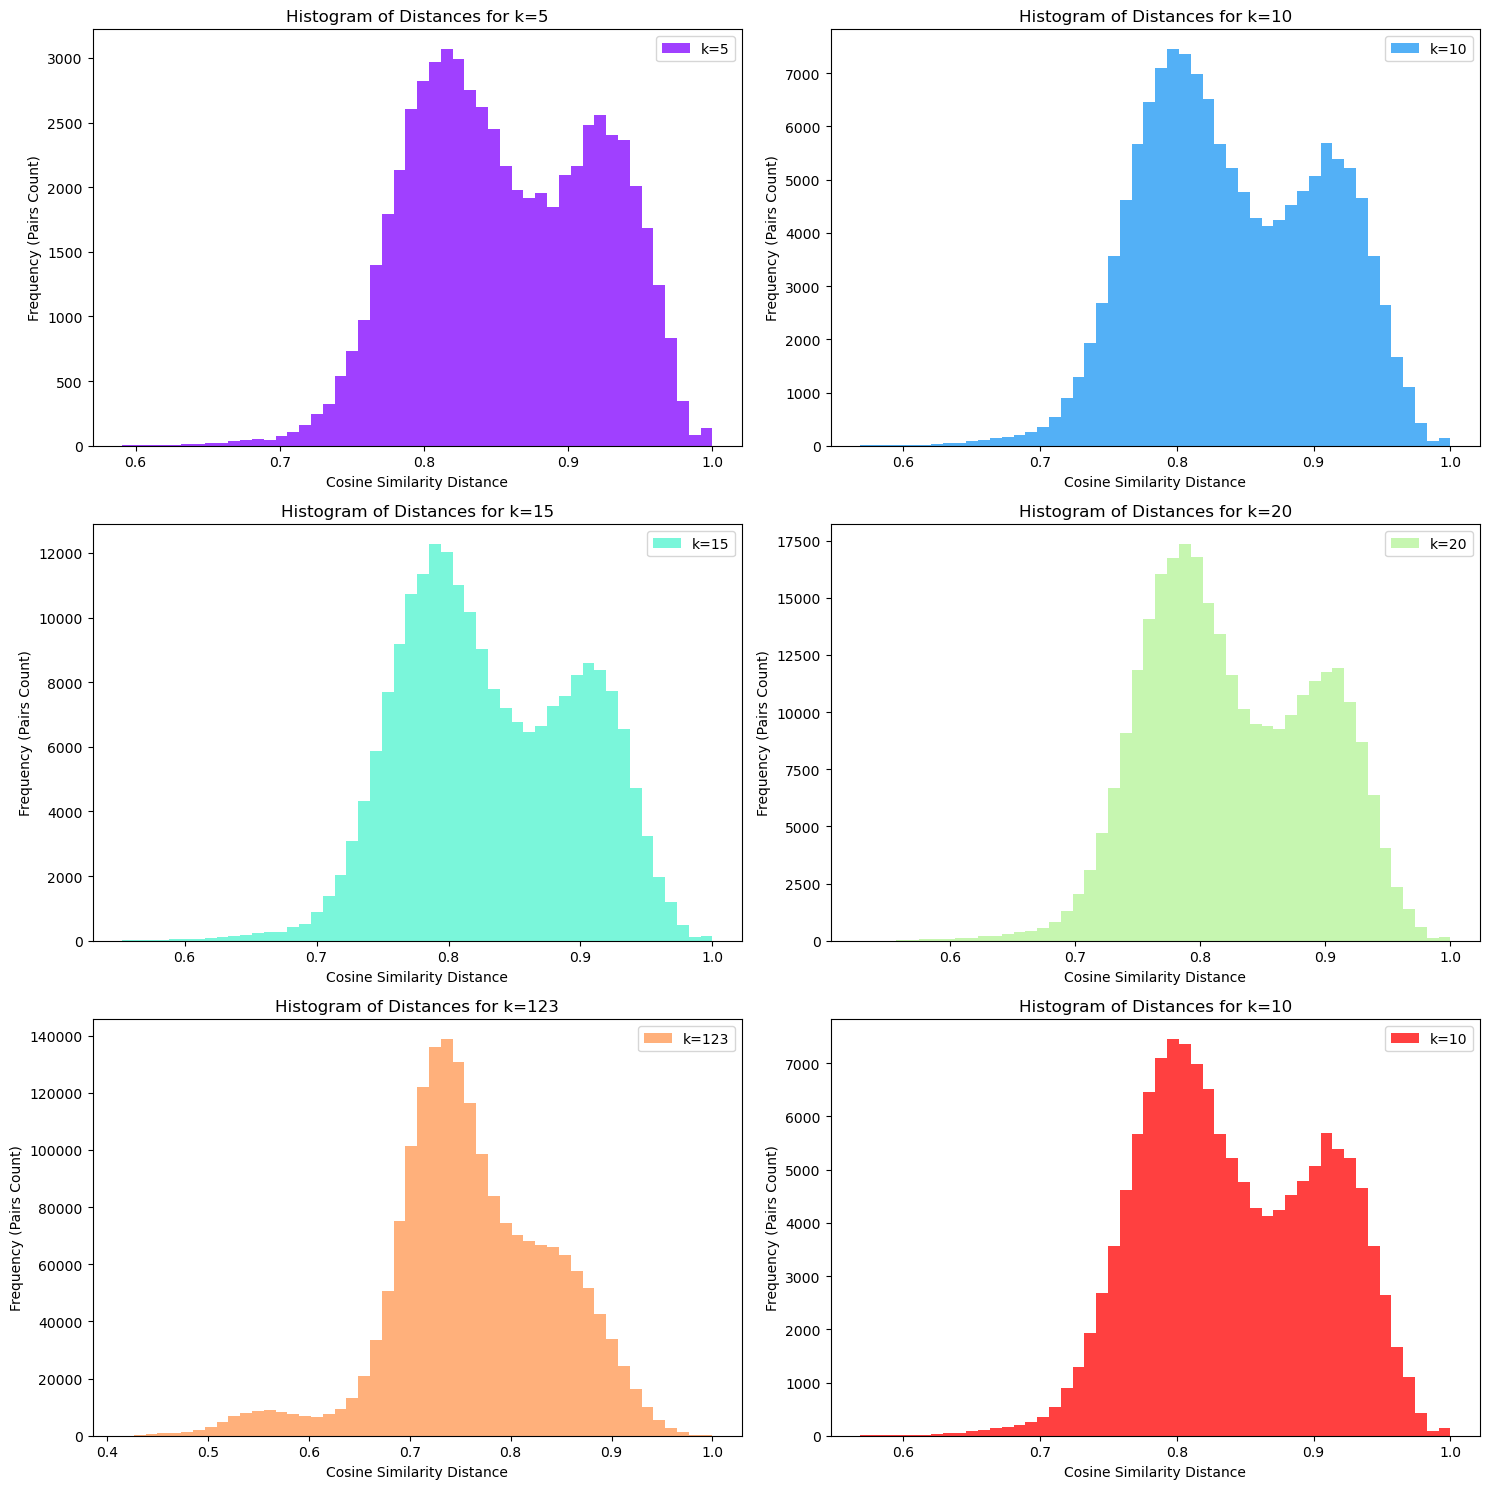

In [19]:
evaluating_thresholds("./embeddings/romi_embeddings/32_H.csv")

Percentiles of Distances for k=5: [0.81268263 0.84281999 0.87972878 0.91946911 0.9375844  0.96263926]
Percentiles of Distances for k=10: [0.79774271 0.82785013 0.86322153 0.90699093 0.92620819 0.95460712]
Percentiles of Distances for k=15: [0.78881149 0.8187798  0.85415065 0.89882243 0.91957053 0.94898781]
Percentiles of Distances for k=20: [0.78226656 0.81231922 0.84756774 0.8927689  0.91447956 0.94494611]
Percentiles of Distances for k=149: [0.72556436 0.75769895 0.79144913 0.83251522 0.86201048 0.90970016]
Percentiles of Distances for k=11: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]
Average Percentiles of Distances: [0.78378944 0.8142025  0.8495287  0.89262251 0.91408563 0.94566729]


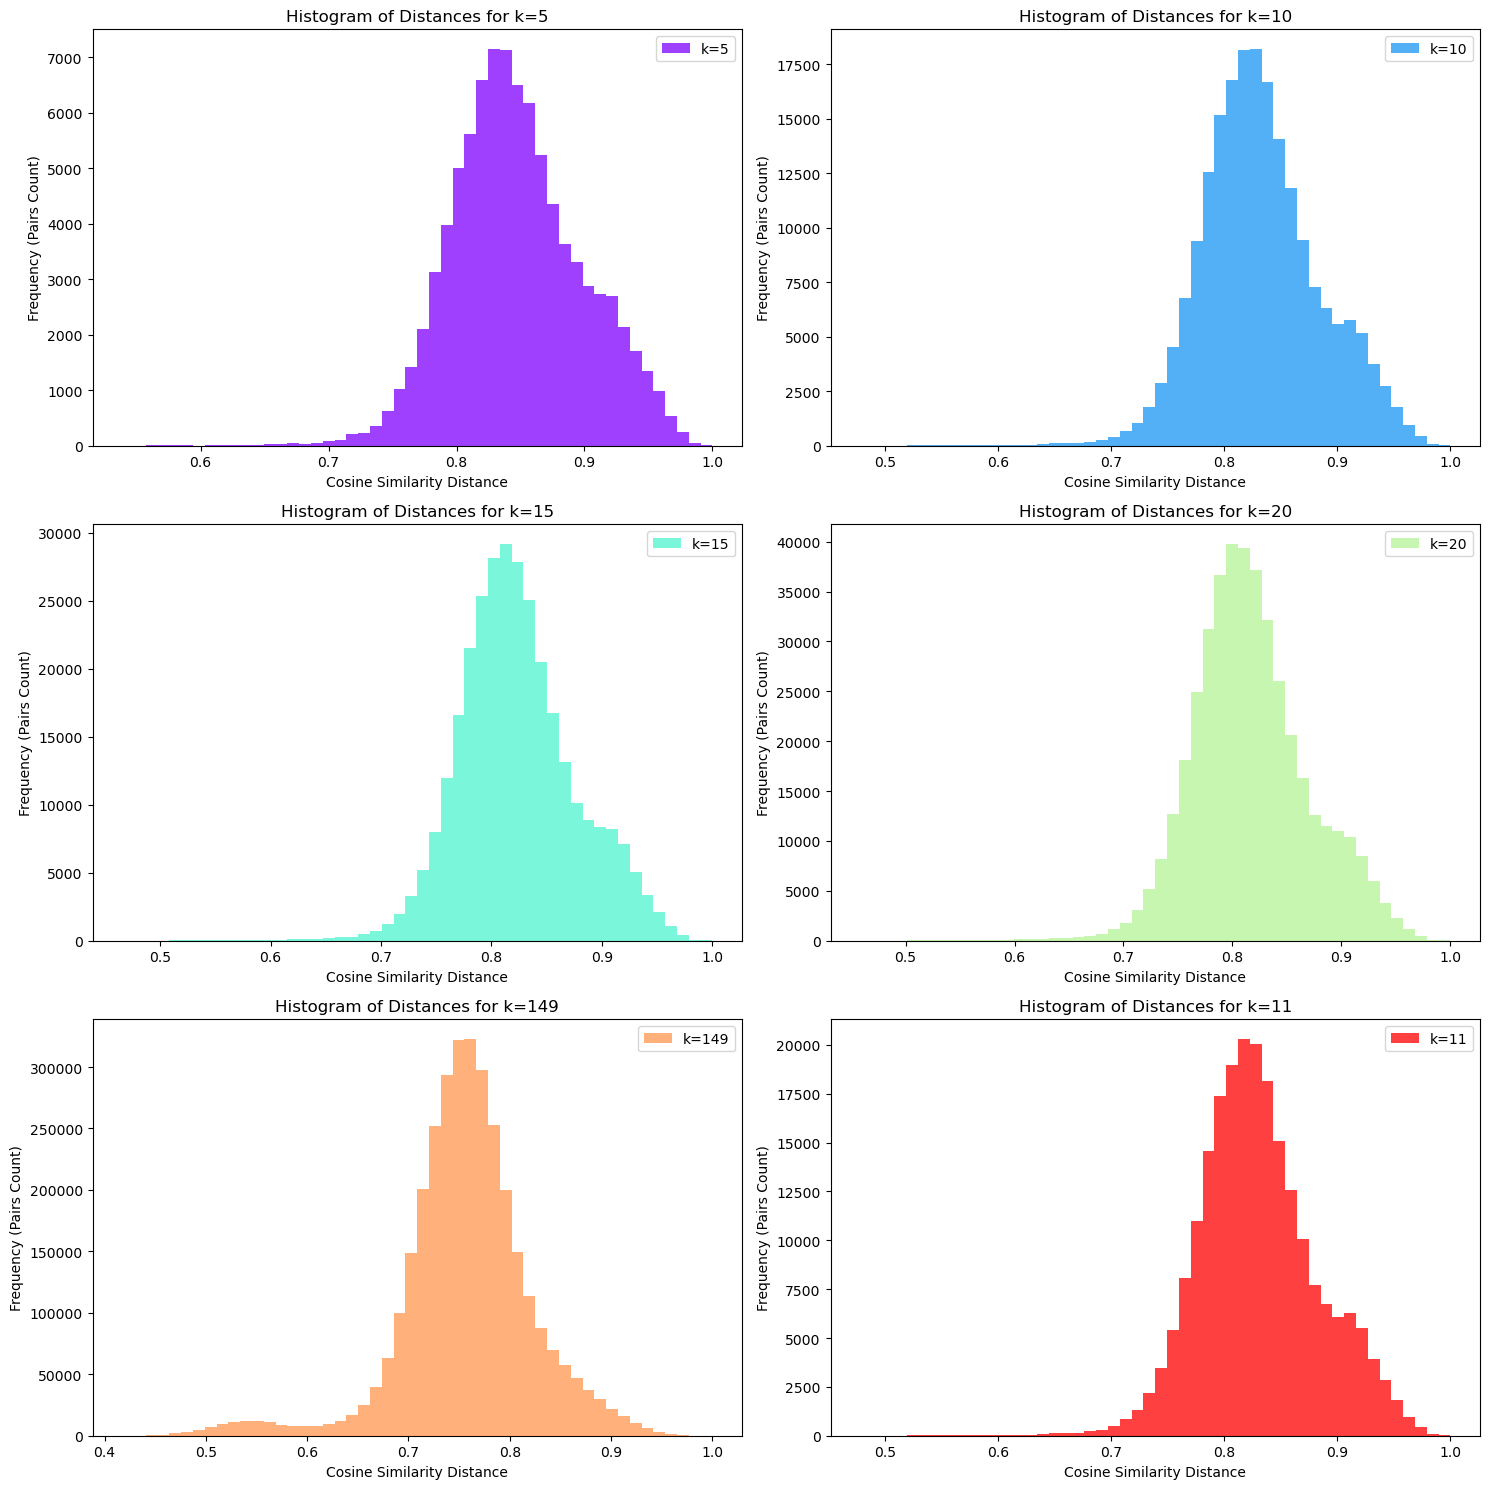

In [17]:
evaluating_thresholds("./embeddings/romi_embeddings/26_OC.csv")

In [10]:
graphs = {}
threshold = 0.9

In [11]:
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_folder, file_name)
        # trimming .csv from file_name
        graphs[file_name.split(".")[0]] = create_graphs_from_embeddings(file_path, threshold)
        

KeyboardInterrupt: 